<a href="https://colab.research.google.com/github/jagonzales6/frugality_thesis/blob/main/code_frugality_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FRUGALITY_CODE**

Es un codigo con 3 funciones desarrolladas y una adicional

1. La primera función genera un mapa de calor el cual correlaciona el total de las subdimensiones de las pruebas en sus puntajes totales
2. La segunda función genera variables aisladas, por ejemplo, solo las correlaciones de "satisfaccion con la vida" con todas las demas variables
3. La tercera funcion genera los valores p de las correlaciones para saber si las correlaciones se han producido por el azar

*Nota:* existe una funciona adicional que usa bootstrap con un total de 1000 iteraciones para probar las muestra tanto en las correlaciones y en el valor p de las correlaciones.

In [ ]:
#Se importa las librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.utils import resample

In [ ]:
url_puntajes_totales = "https://raw.githubusercontent.com/jagonzales6/frugality_thesis/refs/heads/main/data_base/puntajes_totales.csv"
url_demograficos = "https://raw.githubusercontent.com/jagonzales6/frugality_thesis/refs/heads/main/data_base/demograficos.csv"

In [ ]:
#Se lee los archivos con todos los datos
df_puntajes_totales = pd.read_csv(url_puntajes_totales , sep = ",")
df_demogra = pd.read_csv(url_demograficos, sep = ",")

In [ ]:
#se coloca los nombres completos de las variables en los puntajes totales
df_puntajes_totales.rename(columns={'busque_sensasiones': 'UPPS_busqueda_de_sensaciones',
                                               'falta_premeditacon': 'UPPS_falta_de_premeditacion',
                                               'falta_perseverancia': 'UPPS_falta_de_perseverancia',
                                               'urgencia_positiva': 'UPPS_urgencia_positiva',
                                               'urgencia_negativa': 'UPPS_urgencia_negativa',
                                               "satisfacción_vida": "satisfacción_con_la_vida",
                                               "intuitiva" : "sistema_1_intuitivo",
                                               "reflexiva": "sistema_2_reflexivo",
                                               "interno": "locus_de_control_interno",
                                               "casualidad": "locus_de_control_casualidad",
                                               "externo_negación": "locus_de_control_externo_negación",
                                               "otros_poderos": "locus_de_control_otros_poderos",
                                               "coneg": "estilo_atribucional_compuesto_negativo",
                                               "conpos": "estilo_atribucional_compuesto_positivo",
                                               "est_atribucional": "estilo_atribucional"}, inplace=True)

In [ ]:
df_totales = df_puntajes_totales.drop(columns = ["id_sujeto"])
df_demogradicos = df_demogra.drop(columns = ["id_sujeto"])

In [ ]:
# Realizando el join (inner join por defecto)
df_join = pd.merge(df_puntajes_totales, df_demogra, on='id_sujeto')

# PRIMERA FUNCIÓN

Esta función genera un mapa de calor el cual correlaciona el total de las subdimensiones de las pruebas en sus puntajes totales

In [ ]:
def plot_correlation_heatmap(corr_matrix, threshold=0.2, title=''):
    """
    Grafica un mapa de calor de la matriz de correlación con indicadores visuales para correlaciones significativas.

    Args:
        corr_matrix (pd.DataFrame): Matriz de correlación a graficar.
        threshold (float, optional): Umbral para destacar correlaciones significativas. Por defecto es 0.2.
        title (str, optional): Título de la gráfica. Por defecto es 'Correlación entre todas las variables con Spearman en el total de la muestra'.

    Returns:
        None: Muestra el gráfico.
    """
    # Crear un DataFrame para contar las correlaciones mayores que el umbral
    count_above_threshold = (abs(corr_matrix) > threshold).sum() - 1  # Restar 1 para excluir la diagonal

    # Ordenar el DataFrame por el número de correlaciones de mayor a menor
    sorted_indices = count_above_threshold.sort_values(ascending=False).index
    corr_matrix_sorted = corr_matrix.loc[sorted_indices, sorted_indices]
    count_above_threshold_sorted = count_above_threshold[sorted_indices]

    # Crear el heatmap con la matriz de correlación ordenada
    plt.figure(figsize=(14, 12))  # Ajustar el tamaño de la figura
    ax = sns.heatmap(corr_matrix_sorted, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 10})

    # Agregar el título con espacio adicional usando pad
    plt.title(title, pad=20)

    # Ajustar la rotación de las etiquetas del eje x
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    # Añadir círculos amarillos sobre las correlaciones mayores a threshold
    for i in range(corr_matrix_sorted.shape[0]):
        for j in range(corr_matrix_sorted.shape[1]):
            if abs(corr_matrix_sorted.iloc[i, j]) > threshold and i != j:  # Excluir la diagonal
                plt.scatter(j + 0.5, i + 0.5, s=500, facecolors='none', edgecolors='yellow', linewidths=2)

    # Añadir una columna extra para los conteos de correlaciones ordenadas
    for idx, count in enumerate(count_above_threshold_sorted):
        ax.text(corr_matrix_sorted.shape[1] + 0.5, idx + 0.5, f'{count} correlaciones', va='center', ha='left', color='black')

    # Añadir la etiqueta "Número de correlaciones" en la parte superior
    ax.text(corr_matrix_sorted.shape[1] + 0.5, -0.5, 'Número de\ncorrelaciones', va='center', ha='left', color='black', fontweight='bold')

    # Ajustar los límites del gráfico para que se vean los conteos
    ax.set_xlim([0, corr_matrix_sorted.shape[1] + 2])

    # Mostrar la gráfica
    plt.show()

# Ejemplo de uso:
# plot_correlation_heatmap(corr_s)

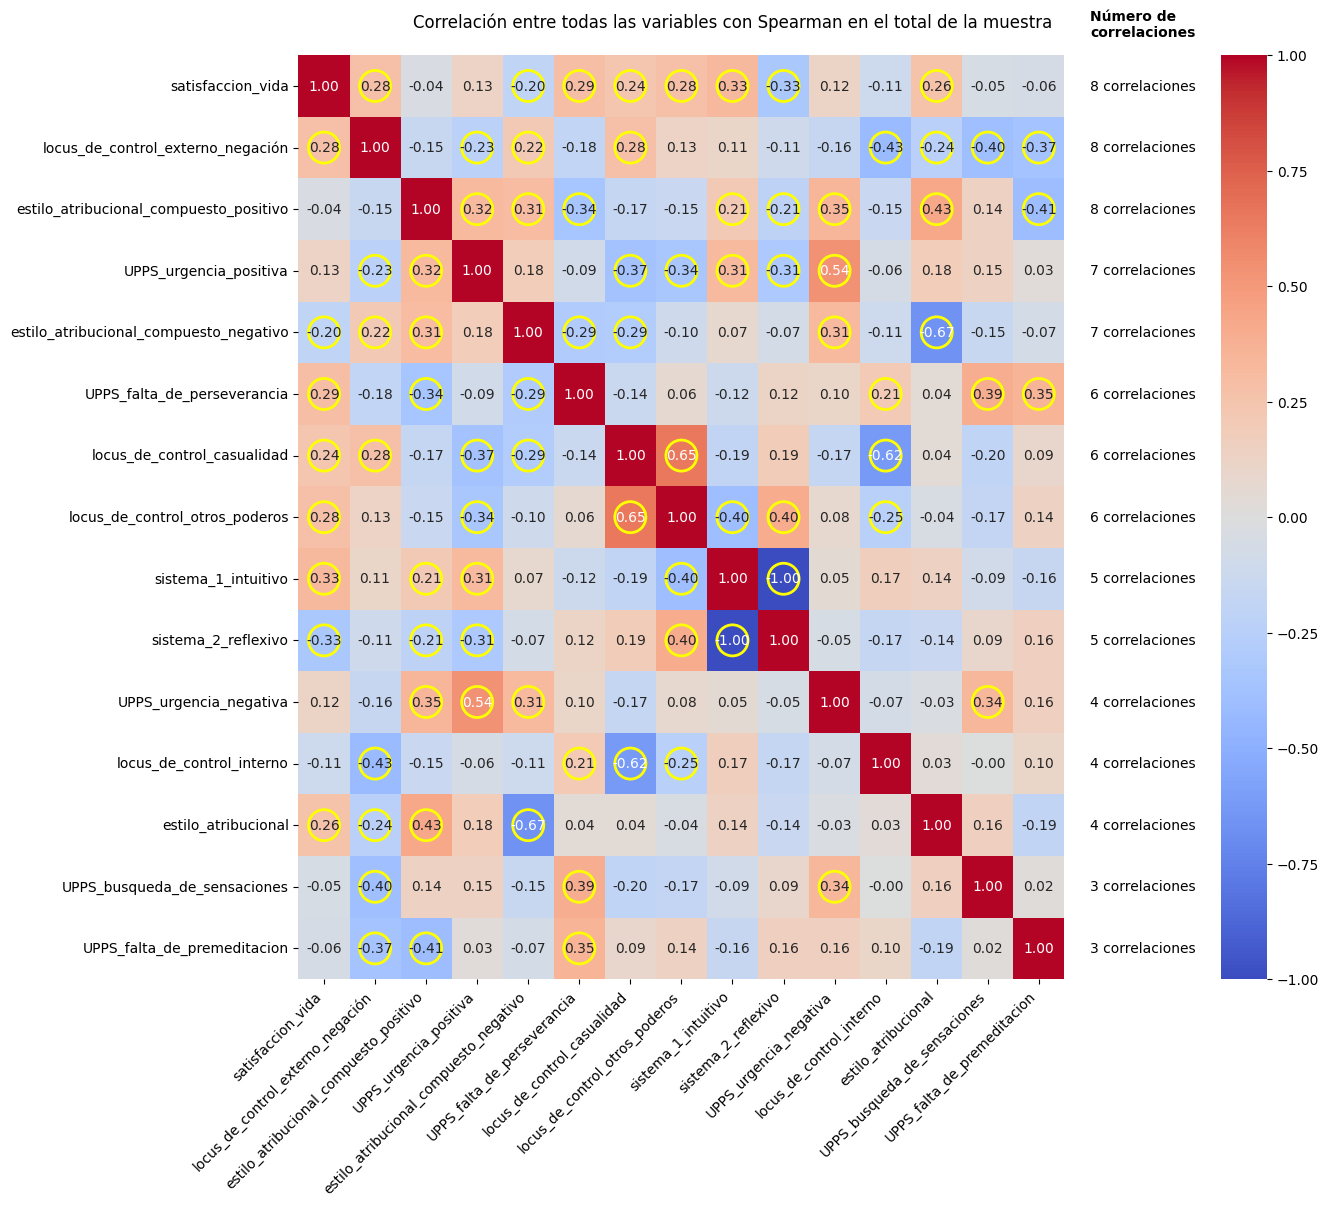

In [ ]:
#Aqui se usa la primera función y se puede graficar el total de los datos
Titulo_grafica = "Correlación entre todas las variables con Spearman en el total de la muestra"
corr_s_total = df_totales.corr(method = "spearman")
plot_correlation_heatmap(corr_s_total, title = Titulo_grafica)

# **SEGUNDA FUNCIÓN**

Esta función genera variables aisladas, por ejemplo, solo las correlaciones de "satisfaccion con la vida" con todas las demas variables


In [ ]:
def plot_cor_one_variable(corr_matrix, variable, threshold=0.2):
    """
    Grafica un mapa de calor de la correlación de una variable específica con otras variables, ordenando por valor absoluto.

    Args:
        corr_matrix (pd.DataFrame): Matriz de correlación a graficar.
        variable (str): La variable de interés para extraer y ordenar sus correlaciones con otras variables.
        threshold (float, optional): Umbral para destacar correlaciones significativas. Por defecto es 0.2.

    Returns:
        None: Muestra el gráfico.
    """
    # Extraer la fila específica
    specific_row = corr_matrix.loc[variable]

    # Eliminar la correlación consigo misma
    specific_row_without_self = specific_row.drop(variable)

    # Ordenar las correlaciones de mayor a menor por el valor absoluto
    specific_row_sorted = specific_row_without_self.abs().sort_values(ascending=False).index
    specific_corr_matrix_sorted = specific_row_without_self[specific_row_sorted].to_frame().transpose()

    # Crear el heatmap con la fila ordenada
    plt.figure(figsize=(14, 2))  # Ajustar el tamaño de la figura
    ax = sns.heatmap(specific_corr_matrix_sorted, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 10})

    # Agregar el título con espacio adicional usando pad
    plt.title(f'Correlación de {variable} con otras variables', pad=20)

    # Ajustar la rotación de las etiquetas del eje x
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')  # Ajustar las etiquetas del eje y

    # Añadir círculos amarillos sobre las correlaciones mayores a threshold
    for j in range(specific_corr_matrix_sorted.shape[1]):
        if abs(specific_corr_matrix_sorted.iloc[0, j]) > threshold:
            plt.scatter(j + 0.5, 0.5, s=600, facecolors='none', edgecolors='yellow', linewidths=2)

    # Contar las correlaciones mayores a 0.20
    count_above_threshold = (abs(specific_corr_matrix_sorted.iloc[0]) > threshold).sum()

    # Añadir el conteo al costado en dos filas
    text = f'Cor > {threshold}: {count_above_threshold}'
    ax.text(specific_corr_matrix_sorted.shape[1] + 0.5, 0.5, text, va='center', ha='left', color='black', fontweight='bold')

    # Ajustar los límites del gráfico para que se vea más compacto
    ax.set_xlim([0, specific_corr_matrix_sorted.shape[1] + 1.5])

    # Ajustar los límites del gráfico para no superponer el texto con la barra de color
    ax.figure.subplots_adjust(right=0.8)

    # Mostrar la gráfica
    plt.show()

# Ejemplo de uso:
# plot_sorted_correlation_heatmap(corr_s, 'satisfaccion_vida')



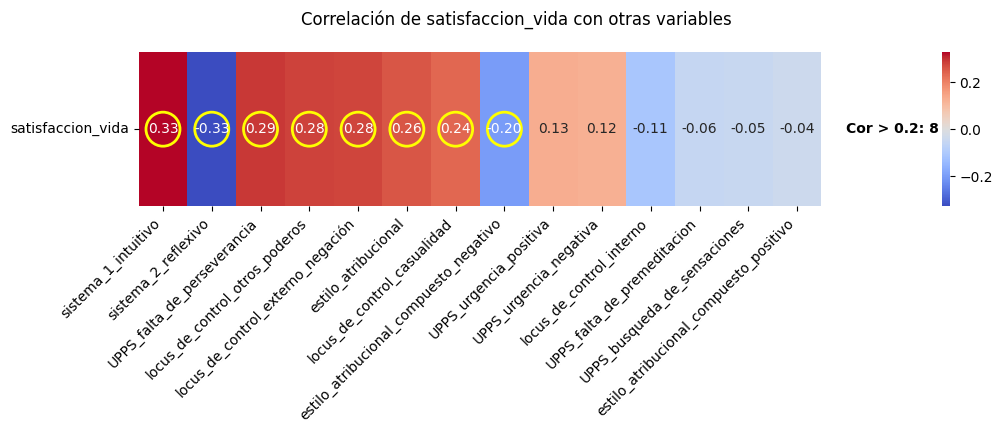

In [ ]:
#Aqui se usa la segunda función y se grafia las variables aisladas
correlacion = corr_s_total
variable_graficar = 'satisfaccion_vida' #aqui se coloca la variable a graficar
plot_cor_one_variable(correlacion, variable_graficar)

# **TERCERA FUNCIÓN**

Esta funcion genera los valores p de las correlaciones para saber si las correlaciones se han producido por el azar

In [ ]:
def plot_cor_with_significance(corr_matrix, data, variable, threshold=0.2):
    """
    Grafica un mapa de calor de la correlación de una variable específica con otras variables
    y genera un tablero con los valores de p para evaluar significancia estadística.

    Args:
        corr_matrix (pd.DataFrame): Matriz de correlación.
        data (pd.DataFrame): Datos originales para calcular p-valores.
        variable (str): La variable de interés.
        threshold (float, optional): Umbral para destacar correlaciones significativas.

    Returns:
        pd.DataFrame: DataFrame con los coeficientes y p-valores.
    """
    # Extraer las correlaciones para la variable específica
    specific_row = corr_matrix.loc[variable].drop(variable)

    # Calcular p-valores para las correlaciones
    p_values = {}
    for col in specific_row.index:
        coef, p_val = spearmanr(data[variable], data[col])
        p_values[col] = p_val

    # Crear un DataFrame con los resultados
    results = pd.DataFrame({
        'Variable': specific_row.index,
        'Correlation': specific_row.values,
        'P-Value': [p_values[col] for col in specific_row.index]
    })
    results['Significance'] = results['P-Value'].apply(lambda p: 'Significant' if p < 0.05 else 'Not Significant')

    # Ordenar los resultados por valor absoluto de la correlación
    results = results.set_index('Variable')
    results = results.reindex(specific_row.abs().sort_values(ascending=False).index)

    # Crear el heatmap
    plt.figure(figsize=(14, 2))
    specific_corr_matrix_sorted = specific_row[results.index].to_frame().transpose()
    ax = sns.heatmap(specific_corr_matrix_sorted, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, annot_kws={"size": 10})

    plt.title(f'Correlación de {variable} con otras variables', pad=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    # Añadir círculos amarillos para correlaciones mayores al threshold
    for j in range(specific_corr_matrix_sorted.shape[1]):
        if abs(specific_corr_matrix_sorted.iloc[0, j]) > threshold:
            plt.scatter(j + 0.5, 0.5, s=600, facecolors='none', edgecolors='yellow', linewidths=2)

    # Mostrar resultados como tabla en consola
    print("Correlation and Significance Table:")
    print(results)

    # Mostrar la gráfica
    plt.show()

    return results


In [ ]:
#aqui se imprimen las columnas y variables que se pueden aislar
df_totales.columns

Correlation and Significance Table:
                                        Correlation   P-Value     Significance
sistema_1_intuitivo                        0.327035  0.118794  Not Significant
sistema_2_reflexivo                       -0.327035  0.118794  Not Significant
UPPS_falta_de_perseverancia                0.290280  0.168821  Not Significant
locus_de_control_otros_poderos             0.278947  0.186839  Not Significant
locus_de_control_externo_negación          0.277632  0.189013  Not Significant
estilo_atribucional                        0.257951  0.223618  Not Significant
locus_de_control_casualidad                0.235694  0.267546  Not Significant
estilo_atribucional_compuesto_negativo    -0.200709  0.347015  Not Significant
UPPS_urgencia_positiva                     0.127856  0.551591  Not Significant
UPPS_urgencia_negativa                     0.122857  0.567377  Not Significant
locus_de_control_interno                  -0.111063  0.605400  Not Significant
UPPS_falta_de_pr

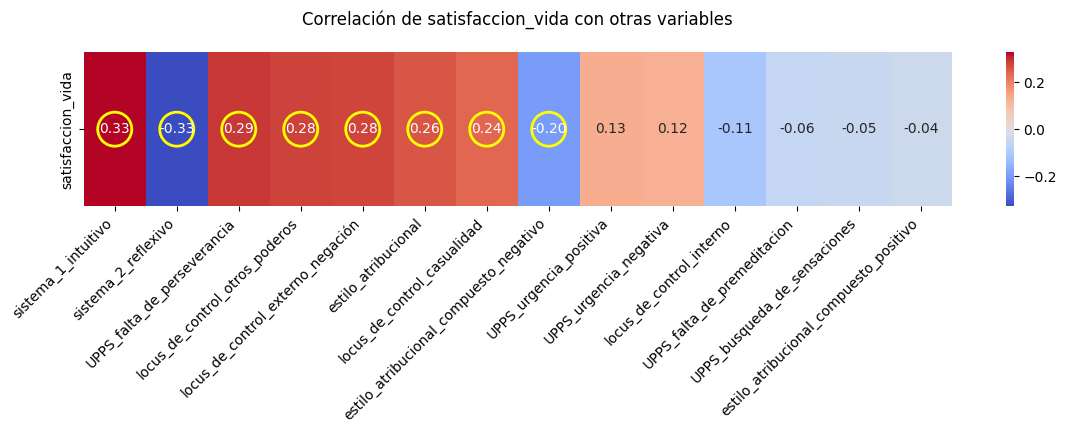

,Correlation,P-Value,Significance
sistema_1_intuitivo,0.327035,0.118794,Not Significant
sistema_2_reflexivo,-0.327035,0.118794,Not Significant
UPPS_falta_de_perseverancia,0.290280,0.168821,Not Significant
locus_de_control_otros_poderos,0.278947,0.186839,Not Significant
locus_de_control_externo_negación,0.277632,0.189013,Not Significant
estilo_atribucional,0.257951,0.223618,Not Significant
locus_de_control_casualidad,0.235694,0.267546,Not Significant
estilo_atribucional_compuesto_negativo,-0.200709,0.347015,Not Significant
UPPS_urgencia_positiva,0.127856,0.551591,Not Significant
UPPS_urgencia_negativa,0.122857,0.567377,Not Significant


In [ ]:
#Aqui se usa la segunda función y se grafia las variables aisladas
correlacion = corr_s_total
variable_graficar = 'satisfaccion_vida' #aqui se coloca la variable a graficar
plot_cor_with_significance(correlacion, df_totales, variable_graficar)

# **FUNCIÓN ADICIONAL BOOTSTRAP**

Esta función usa bootstrap con un total de 1000 iteraciones para probar las muestra tanto en las correlaciones y en el valor p de las correlaciones.


                              Subdimension  Correlation  CI Lower  CI Upper
0             UPPS_busqueda_de_sensaciones    -0.050210 -0.481048  0.388031
1              UPPS_falta_de_premeditacion    -0.056158 -0.436370  0.344195
2              UPPS_falta_de_perseverancia     0.290280 -0.108007  0.608943
3                   UPPS_urgencia_positiva     0.127856 -0.312698  0.520748
4                   UPPS_urgencia_negativa     0.122857 -0.288778  0.512182
5                        satisfaccion_vida     1.000000  1.000000  1.000000
6                      sistema_1_intuitivo     0.327035 -0.084777  0.653957
7                      sistema_2_reflexivo    -0.327035 -0.645116  0.091868
8                 locus_de_control_interno    -0.111063 -0.541778  0.373349
9              locus_de_control_casualidad     0.235694 -0.219022  0.644911
10       locus_de_control_externo_negación     0.277632 -0.128262  0.592305
11          locus_de_control_otros_poderos     0.278947 -0.177556  0.652281
12  estilo_a

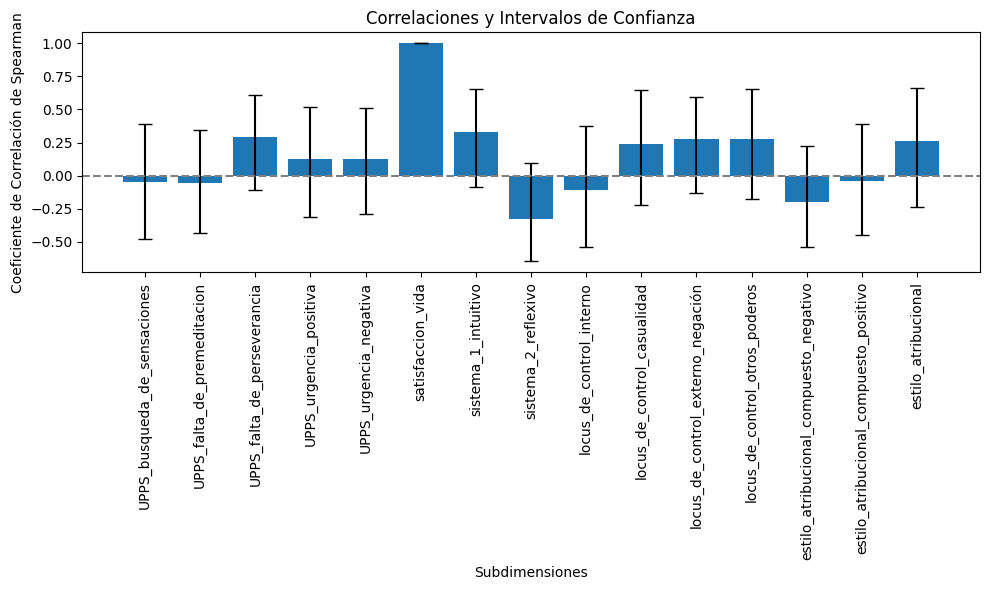

In [ ]:
# Lista de subdimensiones
subdimensiones = [
    'UPPS_busqueda_de_sensaciones', 'UPPS_falta_de_premeditacion',
    'UPPS_falta_de_perseverancia', 'UPPS_urgencia_positiva',
    'UPPS_urgencia_negativa', 'satisfaccion_vida', 'sistema_1_intuitivo',
    'sistema_2_reflexivo', 'locus_de_control_interno',
    'locus_de_control_casualidad', 'locus_de_control_externo_negación',
    'locus_de_control_otros_poderos', 'estilo_atribucional_compuesto_negativo',
    'estilo_atribucional_compuesto_positivo', 'estilo_atribucional'
]

def spearman_bootstrap_ci_matrix(data, target_col, subdimension_cols, n_iterations=1000, confidence_level=0.95):
    """
    Calcula los intervalos de confianza para las correlaciones de Spearman entre una variable
    y múltiples subdimensiones usando bootstrap.

    Args:
        data (pd.DataFrame): DataFrame con los datos.
        target_col (str): Nombre de la variable objetivo.
        subdimension_cols (list): Lista de nombres de columnas de las subdimensiones.
        n_iterations (int): Número de iteraciones para bootstrap.
        confidence_level (float): Nivel de confianza para los intervalos.

    Returns:
        pd.DataFrame: DataFrame con correlaciones originales e intervalos de confianza.
    """
    results = []

    for sub_col in subdimension_cols:
        # Lista para almacenar las correlaciones de bootstrap
        bootstrap_correlations = []

        # Correlación original
        original_corr, _ = spearmanr(data[target_col], data[sub_col])

        # Bootstrap
        for _ in range(n_iterations):
            # Muestra con reemplazo
            sample = resample(data)
            # Calcular la correlación en la muestra bootstrap
            corr, _ = spearmanr(sample[target_col], sample[sub_col])
            bootstrap_correlations.append(corr)

        # Calcular percentiles para el intervalo de confianza
        lower_bound = np.percentile(bootstrap_correlations, (1 - confidence_level) / 2 * 100)
        upper_bound = np.percentile(bootstrap_correlations, (1 + confidence_level) / 2 * 100)

        # Almacenar resultados
        results.append({
            'Subdimension': sub_col,
            'Correlation': original_corr,
            'CI Lower': lower_bound,
            'CI Upper': upper_bound
        })

    # Convertir resultados a DataFrame
    return pd.DataFrame(results)

# Variable objetivo
target_col = 'satisfaccion_vida' #aqui se puede cambiar la variable

# Calcular correlaciones y sus intervalos de confianza
results_df = spearman_bootstrap_ci_matrix(df_totales, target_col, subdimensiones)

# Mostrar resultados
print(results_df)


plt.figure(figsize=(10, 6))
plt.bar(results_df['Subdimension'], results_df['Correlation'], yerr=[results_df['Correlation'] - results_df['CI Lower'], results_df['CI Upper'] - results_df['Correlation']], capsize=5)
plt.axhline(0, color='grey', linestyle='--')
plt.title('Correlaciones y Intervalos de Confianza')
plt.ylabel('Coeficiente de Correlación de Spearman')
plt.xlabel('Subdimensiones')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
